In [1]:
!pip install spacy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
import spacy 

spacy.__version__

'2.2.4'

In [5]:
import torch
import torchtext
from torchtext import datasets

import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
tweets = pd.read_csv('/content/drive/My Drive/depressionrnn/all_nobias.csv', error_bad_lines = False)

tweets.head()

,sentence,condition
0,My 7th year in that school (13years old) was g...,0.0
1,“Clash of the titans!” Caw exclaimed happily.,0.0
2,I hate it.,1.0
3,Starving because I just couldn't leave the saf...,1.0
4,](http://www.esquire.com/news-politics/a23772/...,0.0


In [7]:
tweets = tweets.rename(index = str, columns = {'sentence': 'SentimentText', 'condition': 'Sentiment'})

tweets.head()


,SentimentText,Sentiment
0,My 7th year in that school (13years old) was g...,0.0
1,“Clash of the titans!” Caw exclaimed happily.,0.0
2,I hate it.,1.0
3,Starving because I just couldn't leave the saf...,1.0
4,](http://www.esquire.com/news-politics/a23772/...,0.0


In [0]:
tweets=tweets.dropna()

The dataframe consists of 4 columns and we want to use only ‘Sentiment’ and ‘SentimentText’.

In [9]:
tweets.shape

(5731, 2)

In [10]:
tweets['Sentiment'].unique()

array([0., 1.])

In [11]:
tweets.Sentiment.value_counts()

0.0    3904
1.0    1827
Name: Sentiment, dtype: int64

[Text(0.5, 0, 'Labels')]

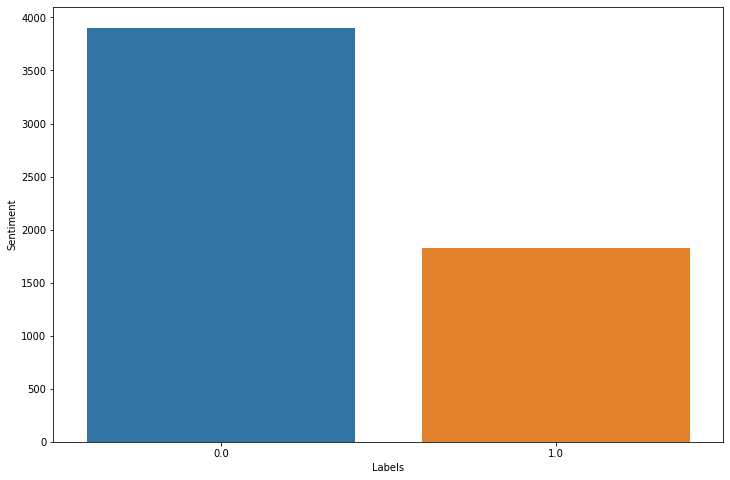

In [12]:
fig = plt.figure(figsize=(12, 8))

ax = sns.barplot(x=tweets.Sentiment.unique(), y=tweets.Sentiment.value_counts())

ax.set(xlabel='Labels')

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(tweets, test_size=0.2, random_state=42)

In [14]:
train.reset_index(drop=True), test.reset_index(drop=True)

(                                          SentimentText  Sentiment
 0     I keep trying and scrambling to pull myself ou...        0.0
 1     She messages me in the morning and says I'm co...        1.0
 2     “Let’s see, twentieth century Sol...” she muse...        0.0
 3     He could feel the eyes of the marines under hi...        0.0
 4     “The whole point of this excursion was to prov...        0.0
 ...                                                 ...        ...
 4579                                        They cheat.        0.0
 4580  My boyfriend is the most amazing person I've e...        0.0
 4581  But its the only thing from the many things i ...        1.0
 4582  But when i went home, she told me to stop talk...        1.0
 4583                              Nemta shook his head.        0.0
 
 [4584 rows x 2 columns],
                                           SentimentText  Sentiment
 0                                   I'm just a dumbass.        1.0
 1     I feel like d

In [15]:
train.shape, test.shape

((4584, 2), (1147, 2))

In [0]:
train.to_csv('/content/drive/My Drive/depressionrnn/train_tweets.csv', index=False)
test.to_csv('/content/drive/My Drive/depressionrnn/test_tweets.csv', index=False)

#### defining a funtion to clean the tweets by removing non alphanumeric character and links 

In [0]:
def tweet_clean(text):
    
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) 
    text = re.sub(r'https?:/\/\S+', ' ', text) 
    
    return text.strip()

####  The tweet column (‘SentimentText’) needs processing and tokenization, so that it can be converted into indices.

In [0]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

def tokenizer(s): 
    return [w.text.lower() for w in nlp(tweet_clean(s))]

In [0]:
TEXT = torchtext.data.Field(tokenize = tokenizer)

LABEL = torchtext.data.LabelField(dtype = torch.float)

In [0]:
datafields = [('SentimentText', TEXT),('Sentiment', LABEL)]

#### We create torchtext dataset,TabularDataset which is specially designed to read csv and tsv files and process them. It is a wrapper around pytorch Dataset with additional features. 

In [0]:
trn, tst = torchtext.data.TabularDataset.splits(path = '/content/drive/My Drive/depressionrnn', 
                                                train = 'train_tweets.csv',
                                                test = 'test_tweets.csv',    
                                                format = 'csv',
                                                skip_header = True,
                                                fields = datafields)

In [24]:
print(f'Number of training examples: {len(trn)}')
print(f'Number of testing examples: {len(tst)}')

Number of training examples: 4584
Number of testing examples: 1147


In [25]:
vars(trn.examples[0])

{'Sentiment': '0.0',
 'SentimentText': ['i',
  'keep',
  'trying',
  'and',
  'scrambling',
  'to',
  'pull',
  'myself',
  'out',
  'of',
  'this',
  'pit',
  'but',
  'as',
  'soon',
  'as',
  'i',
  'm',
  'almost',
  'out',
  'i',
  'get',
  'slammed',
  'into',
  'it',
  'again']}

In [26]:
vars(tst.examples[0])

{'Sentiment': '1.0', 'SentimentText': ['i', 'm', 'just', 'a', 'dumbass']}

#### Load pretrained word vectors and build vocabulary
Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors. We get these vectors simply by specifying which vectors we want and passing it as an argument to build_vocab. TorchText handles downloading the vectors and associating them with the correct words in our vocabulary.

In [27]:
TEXT.build_vocab(trn, max_size=25000,
                 vectors="glove.6B.100d",
                 unk_init=torch.Tensor.normal_)

LABEL.build_vocab(trn)

.vector_cache/glove.6B.zip: 862MB [06:27, 2.22MB/s]                           
100%|█████████▉| 398892/400000 [00:17<00:00, 23169.93it/s]

In [28]:
print(TEXT.vocab.freqs.most_common(50))

[('i', 4137), ('the', 2439), ('to', 2270), ('and', 2018), ('a', 1459), ('of', 1169), ('my', 1163), ('it', 1091), ('that', 904), ('in', 847), ('t', 807), ('me', 730), ('was', 698), ('but', 638), ('for', 586), ('m', 579), ('is', 567), ('this', 542), ('you', 528), ('s', 520), ('with', 512), ('have', 493), ('just', 488), ('so', 468), ('on', 430), ('like', 428), ('not', 423), ('he', 417), ('be', 405), ('she', 388), ('at', 374), ('her', 358), ('they', 356), ('do', 351), ('as', 333), ('all', 316), ('feel', 310), ('can', 309), ('don', 309), ('if', 297), ('had', 294), ('what', 283), ('about', 269), ('we', 262), ('know', 251), ('or', 249), ('up', 246), ('one', 246), ('out', 241), ('get', 240)]


In [29]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'i', 'the', 'to', 'and', 'a', 'of', 'my', 'it']


In [30]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f79dbb3da60>, {'0.0': 0, '1.0': 1})


#### Loading the data in batches
For data with variable length sentences torchtext provides BucketIterator() dataloader which is wrapper around pytorch Dataloader. 

In [0]:
train_iterator, test_iterator = torchtext.data.BucketIterator.splits(
                                (trn, tst),
                                batch_size = 64,
                                sort_key=lambda x: len(x.SentimentText),
                                sort_within_batch=False)

#### We'll be using a different RNN architecture called a Long Short-Term Memory (LSTM).

<b>torch.nn.embedding</b> -A simple lookup table that stores embeddings of a fixed dictionary and size.This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.


<b>LSTM</b> - Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence.

<b>bidirectional</b> - an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the last to the first (a backward RNN). At time step $t$, the forward RNN is processing word $x_t$, and the backward RNN is processing word $x_{T-t+1}$.


<b>Dropout</b> - it works by randomly dropping out (setting to 0) neurons in a layer during a forward pass. The probability that each neuron is dropped out is set by a hyperparameter and each neuron with dropout applied is considered indepenently.This helps in regularization.


In [0]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, 
                 output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers, 
                           bidirectional = bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, text):
        
        embedded = self.dropout(self.embedding(text))
        
        output, hidden = self.rnn(embedded)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
       
        return self.fc(hidden.squeeze(0))

To ensure the pre-trained vectors can be loaded into the model, the EMBEDDING_DIM must be equal to that of the pre-trained GloVe vectors loaded earlier.

We get our pad token index from the vocabulary, getting the actual string representing the pad token from the field's pad_token attribute, which is pad by default.

In [0]:
input_dim = len(TEXT.vocab)

embedding_dim = 100

hidden_dim = 20
output_dim = 1

n_layers = 2
bidirectional = True

dropout = 0.5

In [81]:
input_dim

8038

In [0]:
model = RNN(input_dim, 
            embedding_dim, 
            hidden_dim, 
            output_dim, 
            n_layers, 
            bidirectional, 
            dropout)

In [83]:
model

RNN(
  (embedding): Embedding(8038, 100)
  (rnn): GRU(100, 20, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

We retrieve the embeddings from the field's vocab, and check they're the correct size, [vocab size, embedding dim]

In [84]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([8038, 100])


We then replace the initial weights of the embedding layer with the pre-trained embeddings.

In [85]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.4096, -2.0166, -0.1875,  ...,  0.5066,  1.1730,  1.9223],
        [ 0.8996, -1.5762, -0.0165,  ..., -0.1365,  2.3520,  1.8077],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-0.5879,  0.0165, -0.6412,  ...,  0.1248,  0.0362, -0.3741],
        [ 0.5732, -1.0756, -0.1600,  ...,  0.4548,  0.2344,  0.0364],
        [-0.2909, -0.7498, -0.2997,  ..., -0.4769,  0.4399, -0.2560]])

As our < unk > and < pad > token aren't in the pre-trained vocabulary they have been initialized using unk_init (an $\mathcal{N}(0,1)$ distribution) when building our vocab. It is preferable to initialize them both to all zeros to explicitly tell our model that, initially, they are irrelevant for determining sentiment.

In [86]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-0.5879,  0.0165, -0.6412,  ...,  0.1248,  0.0362, -0.3741],
        [ 0.5732, -1.0756, -0.1600,  ...,  0.4548,  0.2344,  0.0364],
        [-0.2909, -0.7498, -0.2997,  ..., -0.4769,  0.4399, -0.2560]])


#### Train the Model

We use Adam optimizer and loss function is BCEWithLogitLoss 

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(),lr=0.0005)

criterion = nn.BCEWithLogitsLoss()

#### We define a function for training our model
as we are now using dropout, we must remember to use model.train() to ensure the dropout is "turned on" while training.

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.SentimentText).squeeze(1)
        
        loss = criterion(predictions, batch.Sentiment)
        
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.Sentiment).float() 
        
        acc = correct.sum() / len(correct)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [89]:
num_epochs = 18

for epoch in range(num_epochs):
     
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in test_iterator:

            predictions = model(batch.SentimentText).squeeze(1)

            loss = criterion(predictions, batch.Sentiment)

            rounded_preds = torch.round(torch.sigmoid(predictions))
            correct = (rounded_preds == batch.Sentiment).float() 
            
            acc = correct.sum()/len(correct)

            epoch_loss += loss.item()
            epoch_acc += acc.item()


    test_loss = epoch_loss / len(test_iterator)
    test_acc = epoch_acc / len(test_iterator)

    
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% |')
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

| Epoch: 01 | Train Loss: 0.648 | Train Acc: 64.76% |
Test Loss: 0.628 | Test Acc: 67.79%
| Epoch: 02 | Train Loss: 0.616 | Train Acc: 68.19% |
Test Loss: 0.613 | Test Acc: 68.23%
| Epoch: 03 | Train Loss: 0.593 | Train Acc: 68.28% |
Test Loss: 0.611 | Test Acc: 64.99%
| Epoch: 04 | Train Loss: 0.536 | Train Acc: 71.67% |
Test Loss: 0.604 | Test Acc: 66.76%
| Epoch: 05 | Train Loss: 0.515 | Train Acc: 73.97% |
Test Loss: 0.634 | Test Acc: 64.77%
| Epoch: 06 | Train Loss: 0.502 | Train Acc: 74.75% |
Test Loss: 0.616 | Test Acc: 65.90%
| Epoch: 07 | Train Loss: 0.482 | Train Acc: 75.49% |
Test Loss: 0.667 | Test Acc: 62.85%
| Epoch: 08 | Train Loss: 0.471 | Train Acc: 77.03% |
Test Loss: 0.586 | Test Acc: 68.95%
| Epoch: 09 | Train Loss: 0.447 | Train Acc: 78.82% |
Test Loss: 0.580 | Test Acc: 69.39%
| Epoch: 10 | Train Loss: 0.449 | Train Acc: 79.01% |
Test Loss: 0.560 | Test Acc: 71.47%
| Epoch: 11 | Train Loss: 0.434 | Train Acc: 79.80% |
Test Loss: 0.584 | Test Acc: 69.12%
| Epoch: 1

### Testing the model

In [188]:
epoch_loss = 0
epoch_acc = 0

model.eval()

with torch.no_grad():

    for batch in test_iterator:

        predictions = model(batch.SentimentText).squeeze(1)

        loss = criterion(predictions, batch.Sentiment)

        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.Sentiment).float() 
        
        acc = correct.sum()/len(correct)

        epoch_loss += loss.item()
        epoch_acc += acc.item()


test_loss = epoch_loss / len(test_iterator)
test_acc = epoch_acc / len(test_iterator)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.511 | Test Acc: 76.24%


#### User Input
We can now use our model to predict the sentiment of any sentence we give it.As it has been trained on tweets, the sentences provided should in a positive or a negative context.

We are expecting tweets with a negative sentiment to return a value close to 1 and positive tweets to return a value close to 0


In [0]:
sentence = ''

In [0]:
tokenized = [tok.text for tok in nlp.tokenizer(sentence)]

In [0]:
indexed = [TEXT.vocab.stoi[t] for t in tokenized]

In [0]:
tensor = torch.LongTensor(indexed)

In [0]:
tensor = tensor.unsqueeze(1)

In [0]:
prediction = torch.sigmoid(model(tensor))

In [187]:
prediction.item()

0.9267289042472839

In [189]:
torch.save(model, '/content/drive/My Drive/depressionrnn/seventysix.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
model = torch.load('/content/drive/My Drive/depressionrnn/eightyALL.pt')
model.eval()

RNN(
  (embedding): Embedding(8038, 100)
  (rnn): GRU(100, 20, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [0]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-2.5223e-04,  3.6638e-02, -1.2487e-02,  ...,  7.1077e-02,
          -6.3295e-03, -4.3267e-02],
         [-1.5668e-02,  5.9423e-01,  6.9866e-01,  ..., -4.8228e-01,
           4.0013e-02,  8.0493e-01],
         ...,
         [-7.0798e-01, -1.0008e-01, -7.5247e-01,  ...,  2.3203e-01,
          -9.9558e-02, -2.4126e-01],
         [ 5.0150e-01, -1.1540e+00, -2.2011e-01,  ...,  5.4036e-01,
           2.1950e-01,  1.2718e-01],
         [-3.6145e-01, -8.6555e-01, -3.8274e-01,  ..., -5.0392e-01,
           4.9332e-01, -1.9343e-01]], requires_grad=True),
 Parameter containing:
 tensor([[-0.0389,  0.1417,  0.1798,  ..., -0.1074,  0.1154, -0.1111],
         [ 0.0304, -0.0568, -0.1228,  ...,  0.1031,  0.2214, -0.0489],
         [-0.1973,  0.0014,  0.1398,  ...,  0.1347,  0.0105, -0.0006],
         ...,
         [-0.1481, -0.0159,  0.2606,  ...,  0.1536, -0.1178, 

Now We gotta build the second RNN to understand the relations between sentences


In [0]:
import numpy as np
from nltk.tokenize import sent_tokenize

In [193]:
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
para = pd.read_csv('/content/drive/My Drive/depressionrnn/paradataset.csv')

In [0]:
lmao=para[0:20]

In [0]:
input_data = {'condition':[]}


In [0]:
for i in range(len(para)):
  input_data['condition'].append(para.loc[i, "condition"])
  



In [0]:
to_mer= pd.DataFrame(input_data,columns =['condition'])

In [0]:
l=0
m=0
for i in range(len(para)):
  sent_tokens = sent_tokenize(para.loc[i, "submission"])
  l=l+len(sent_tokens)
m=l/i

In [0]:
m

35.506864988558355

In [0]:
vec_sentence = {}

In [0]:
for i in range(len(para)):
  sent_tokens = sent_tokenize(para.loc[i, "submission"])
  for i in range(len(sent_tokens)):
    tokenized = [tok.text for tok in nlp.tokenizer(sent_tokens[i])]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed)
    tensor = tensor.unsqueeze(1)
    prediction = torch.sigmoid(model(tensor))
    vec_sentence.setdefault(i,[]).append(prediction.item())
  if i<580:
    for i in range(i+1,580):
      vec_sentence.setdefault(i,[]).append(0.0)

In [0]:
vec_sent = pd.DataFrame(vec_sentence)

In [0]:
average_vec_sent=vec_sent.iloc[:,0:36]

In [0]:
average_vec_sent.sample(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
335,0.807537,0.943191,0.009136,0.002906,0.962754,0.004715,0.008831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1711,0.000331,0.001359,0.003030,0.016530,0.001273,0.001304,0.000563,0.001198,0.001701,0.351126,0.001891,0.000723,0.022999,0.015549,0.024722,0.001973,0.000289,0.034086,0.00641,0.014226,0.013526,0.004714,0.02879,0.374671,0.961756,0.419337,0.71161,0.000983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


mean value of number of sentences = 36

In [0]:
data_para_vectors = pd.DataFrame.from_dict(input_data)

In [0]:
sent_tokens = sent_tokenize("") 


In [0]:
input_data = []
sent_tokens

['i am fed up with my life.',
 'There is nothing much left.',
 'I want to die.',
 'i like taking  walks by the  beach']

In [0]:
for sentence in sent_tokens:
  tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
  indexed = [TEXT.vocab.stoi[t] for t in tokenized]
  tensor = torch.LongTensor(indexed)
  tensor = tensor.unsqueeze(1)
  prediction = torch.sigmoid(model(tensor))
  input_data.append(prediction.item())
  


In [0]:
input_data

[0.9255887269973755,
 0.8959446549415588,
 0.9133660793304443,
 0.11528420448303223]

In [0]:
data_para_vectors

,sentence,condition
0,"[0.023430433124303818, 0.10041609406471252, 0....",0
1,"[0.7287686467170715, 0.13594579696655273, 0.07...",1
2,"[0.019319090992212296, 0.8115354180335999, 0.0...",0
3,"[0.9652117490768433, 0.9601704478263855, 0.974...",1
4,"[0.01882638968527317, 0.017171267420053482, 0....",0
...,...,...
1744,"[0.02131967432796955, 0.021098053082823753, 0....",0
1745,"[0.021219639107584953, 0.0192734282463789, 0.0...",0
1746,"[0.18058808147907257, 0.8963363170623779, 0.93...",1
1747,"[0.2600974440574646, 0.018560275435447693, 0.0...",0


In [0]:
data_para_vectors.to_csv('/content/drive/My Drive/depressionrnn/para_vectors.csv', index=False)

In [0]:
data_para_vectors = pd.read_csv('/content/drive/My Drive/depressionrnn/para_vectors.csv')

In [0]:
to_mer = data_para_vectors.iloc[:,1:]

In [0]:
to_mer

,condition
0,0
1,1
2,0
3,1
4,0
...,...
1744,0
1745,0
1746,1
1747,0


In [0]:
average_vec_sent

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,0.021249,0.029183,0.009153,0.863360,0.437762,0.027893,0.034607,0.009567,0.539730,0.023512,0.010532,0.073112,0.032779,0.013092,0.015442,0.016392,0.055576,0.015903,0.011706,0.011917,0.014009,0.013470,0.077795,0.016448,0.687319,0.027469,0.062830,0.017083,0.335660,0.133792,0.470579,0.015406,0.017100,0.034288,0.015089,0.497672
1,0.806606,0.128510,0.136395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.013921,0.856608,0.015094,0.032395,0.958026,0.903783,0.643045,0.772588,0.973150,0.067712,0.273345,0.818307,0.206419,0.153157,0.766966,0.018340,0.025191,0.009675,0.019293,0.249056,0.024023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.942060,0.982114,0.983963,0.036931,0.643927,0.967281,0.946222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.013459,0.011142,0.014239,0.014808,0.021258,0.023457,0.014128,0.015280,0.010230,0.010001,0.015189,0.011412,0.015431,0.017493,0.012073,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,0.016779,0.016226,0.015499,0.013974,0.715402,0.013519,0.011302,0.012160,0.965153,0.015847,0.861451,0.021216,0.095369,0.019180,0.010733,0.038995,0.018170,0.019020,0.364901,0.010777,0.024120,0.018600,0.009852,0.026009,0.149471,0.045852,0.017224,0.012048,0.024373,0.017340,0.150561,0.013599,0.010900,0.013412,0.027110,0.011038
1743,0.014215,0.009749,0.015046,0.024823,0.017891,0.011946,0.011123,0.013225,0.010650,0.013751,0.011576,0.012770,0.010118,0.013741,0.032768,0.251493,0.026829,0.011291,0.009629,0.013361,0.019585,0.109740,0.011663,0.026420,0.016733,0.014017,0.015811,0.016686,0.012995,0.012610,0.019966,0.016812,0.019783,0.013839,0.033524,0.024873
1744,0.253411,0.627633,0.968265,0.032800,0.768215,0.532675,0.935778,0.015314,0.154825,0.015683,0.014456,0.116663,0.119161,0.099314,0.021685,0.894721,0.019328,0.054429,0.774793,0.811992,0.046720,0.015591,0.013781,0.759258,0.015267,0.152117,0.928234,0.013049,0.040625,0.031172,0.013982,0.107106,0.074915,0.969812,0.916486,0.016836
1745,0.343709,0.010765,0.044594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [0]:
sent_numeric = pd.merge(to_mer,average_vec_sent,left_index=True,right_index=True)

In [0]:
sent_numeric.sample(20)

,condition,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
68,1,0.740276,0.022239,0.022524,0.003498,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
505,0,0.170613,0.014809,0.957401,0.740263,0.864061,0.301272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1600,1,0.855699,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
942,1,0.009630,0.065301,0.029075,0.000756,0.006052,0.011120,0.002487,0.022104,0.011771,0.783413,0.010061,0.002015,0.122728,0.906303,0.227663,0.001429,0.006626,0.001797,0.001996,0.029768,0.038406,0.006570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
322,1,0.006917,0.002116,0.001099,0.534396,0.005031,0.745344,0.972241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
111,1,0.000403,0.003856,0.032672,0.010316,0.004237,0.001165,0.020629,0.003802,0.002838,0.027955,0.001272,0.002820,0.013056,0.011720,0.002576,0.002345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1101,0,0.016545,0.269982,0.007317,0.002475,0.013001,0.004108,0.064349,0.003214,0.003627,0.052068,0.012100,0.016415,0.018239,0.002740,0.001176,0.011608,0.002122,0.003164,0.004044,0.019285,0.004025,0.000880,0.003340,0.009337,0.008010,0.051564,0.001838,0.002093,0.006431,0.004131,0.004077,0.005555,0.013799,0.006962,0.007356,0.003480
411,0,0.004221,0.093995,0.102958,0.040028,0.003020,0.002528,0.003306,0.007483,0.670545,0.205594,0.541328,0.859905,0.012168,0.035211,0.073337,0.001573,0.056919,0.457170,0.001171,0.248678,0.005324,0.056279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1189,0,0.006527,0.002126,0.008283,0.009425,0.000520,0.510950,0.006309,0.023168,0.002625,0.002894,0.009659,0.001271,0.001242,0.023453,0.001619,0.003951,0.016812,0.031685,0.012040,0.000833,0.005749,0.016095,0.002858,0.008620,0.004044,0.005108,0.000432,0.037876,0.003873,0.001078,0.000936,0.008555,0.012211,0.879532,0.001244,0.003442
1435,1,0.998414,0.157498,0.075853,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [0]:
sent_numeric.to_csv('/content/drive/My Drive/depressionrnn/sent_numeric_final.csv',index=False)

In [0]:
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
input_size = 36 #Always Check
output_size = 2
hidden_size = 100

In [0]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        #self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size) 
    
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        #x = F.sigmoid(self.fc3(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=-1)

In [0]:
model_para = torch.load('/content/drive/My Drive/depressionrnn/parapred.pt')
model_para.eval()

Net(
  (fc1): Linear(in_features=36, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)

FINAL WORKING OF THE PROJECT!!!


In [0]:
user_para= "please tell me this stupid algorithm works. I am very sad and lonely"

In [196]:
sent_tokens = sent_tokenize(user_para)
numeric_symptoms_sent_list=[]
length= 0
for sentence in sent_tokens:
  print(sentence)
  tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
  indexed = [TEXT.vocab.stoi[t] for t in tokenized]
  tensor = torch.LongTensor(indexed)
  tensor = tensor.unsqueeze(1)
  prediction = torch.sigmoid(model(tensor))
  numeric_symptoms_sent_list.append(prediction.item())
print(numeric_symptoms_sent_list)


please tell me this stupid algorithm works.
I am very sad and lonely
[0.21939747035503387, 0.8963074088096619]


In [0]:
length = len(numeric_symptoms_sent_list)
if length<36:
  for i in range(length,36):
    numeric_symptoms_sent_list.append(0.0)   
sample = np.array(numeric_symptoms_sent_list)
sample_tensor = torch.from_numpy(sample).float()
out = model_para(sample_tensor)
_,predicted = torch.max(out.data,-1)

if predicted.item()==1:
  print("depression symptoms present")
else:
  print("depression symptoms absent")



depression symptoms present


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
